In [48]:
import os
import sys

if os.path.abspath('../..') not in sys.path:
    sys.path.append(os.path.abspath('../..'))
    
import json
import shutil
import datetime

from dateutil.relativedelta import relativedelta
import tqdm

import scipy
import scipy.stats as st
from scipy.spatial import distance

import numpy as np
import pandas as pd

from sqlalchemy.orm.exc import NoResultFound

from src.corpus import load_tweets
from src.dataset import load_dataset 
from src.config import config
from src.utils.backup import FileBackup
from src.dashboard.models import db, Collection, CollectionTopicProba, Document, TopicModelLoader, Topic, Subject
from src.dashboard.app import app

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [49]:
import numpy as np
import pandas as pd
import scipy.special
from scipy import stats

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show

In [50]:
def histplot(data=None, *, x=None, y=None, weights=None, bins='auto', stat='count', 
             cumulative=False, kde=False, kde_kws=None, legend=True, legend_kws=None, fig_kwgs=None):
    if legend_kws is None:
        legend_kws = {}
    if fig_kwgs is None:
        fig_kwgs = {}
    density = stat == 'density'
    measured = data.loc[:, y if y is not None else x] if isinstance(data, pd.DataFrame) else data
    hist, edges = np.histogram(measured, density=density, bins=bins, weights=weights)
    x = np.linspace(edges[0], edges[-1], 2000)
    # plot
    p = figure(tools='', background_fill_color="#fafafa", **fig_kwgs)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy",
           line_color="white", alpha=0.5)
    if kde:
        kernel = stats.gaussian_kde(measured)
        pdf = kernel(x)
        p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="PDF")
    if cumulative:
        pass
        # cdf = (1+scipy.special.erf((x-mu)/np.sqrt(2*sigma**2)))/2
        # p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend_label="CDF")
    p.y_range.start = 0
    if legend:
        p.legend.location = legend_kws.get('location', 'center_right')
        p.legend.background_fill_color = legend_kws.get('background_fill_color', '#fefefe')
    p.xaxis.axis_label = legend_kws.get('axis_label', 'x')
    p.yaxis.axis_label = legend_kws.get('axis_label', 'Pr(x)')
    p.grid.grid_line_color = legend_kws.get('grid_line_color', 'white')
    return p

In [51]:
POSITIONS_MAP = {
    'Meteorologist': 'Meteorologist',
    'Reporter': 'Reporter',
    'Producer': 'Reporter',
    'Journalist': 'Reporter',
    'Editor': 'Reporter',
    'Other': 'Other',
    'Student': 'Other',
    'Academic': 'Other',
    'Met Producer': 'Meteorologist',
    'News Director': 'Reporter',
    'Vice President': 'Reporter', 
    'Photographer': 'Reporter'
}

In [52]:
with app.app_context():
    model_loader = None
    for model_loader in TopicModelLoader.query.all():
        if (model_loader.model.num_epochs, model_loader.model.num_topics) == (1, 6):
            break
    cs = Collection.query.all()
    data, tuples = [], []
    for c in tqdm.tqdm(cs, desc='Collecting Collection Probabilities'):
        topics = c.get_topic_dist(model_loader)
        proba_sum = 0
        for t in topics:
            proba_sum += t.proba
        # sum of proba sum should be 1.0
        # if not(proba_sum > 0.5):
        #     continue
        if c.subject is None:
            continue
        event_id = 'None'
        event_type = 'None'
        if c.event:
            event_id = c.event.id
            event_type = c.event.event_type
        groups = c.group.split('-')
        index = 0
        try:
            index = int(groups[-1])
            group = '-'.join(groups[:-1])
        except ValueError as ex:
            group = '-'.join(groups)
        tuples += [(c.id, c.type, group, index, c.subject_id, event_id, event_type, c.subject.position)]
        data.append({topic_proba.topic.label: topic_proba.proba for i, topic_proba in enumerate(topics)})
    index = pd.MultiIndex.from_tuples(tuples, names=['id', 'type', 'group', 'index', 'subject_id', 
                                                     'event_id', 'event_type', 'position'])
    df = pd.DataFrame.from_records(data)
    df.index = index
    relevant_topics = Topic.query.filter(
        Topic.topic_model_loader_id == model_loader.id,
        Topic.is_relevant.is_(True),
    ).all()

In [58]:
meta_df = df.index.to_frame().reset_index(drop=True)[['group', 'event_type', 'position', 'subject_id', 'event_id']].drop_duplicates()

meta_df['Event Type'] = meta_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
meta_df = meta_df.assign(Position=meta_df['position'].map(POSITIONS_MAP))

meta_df = meta_df[meta_df['Position'] != 'Other']

meta_1_df = meta_df.pivot_table(index=['Event Type'], columns=['Position'], values='subject_id', aggfunc='count')

print(meta_1_df.to_latex())

\begin{tabular}{lrr}
\toprule
Position &  Meteorologist &  Reporter \\
Event Type &                &           \\
\midrule
Join       &           1468 &       604 \\
Workshop   &             48 &       344 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_7504/2642016999.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_1_df.to_latex())


In [59]:
meta_df = df.index.to_frame().reset_index(drop=True)[['group', 'event_type', 'position', 'subject_id', 'event_id']].drop_duplicates()

meta_df['Event Type'] = meta_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
meta_df = meta_df.assign(Position=meta_df['position'].map(POSITIONS_MAP))

meta_df = meta_df[meta_df['Position'] != 'Other']

meta_1_df = meta_df.pivot_table(index=['group'], columns=['Position'], values='subject_id', aggfunc='count')

print(meta_1_df.to_latex())

\begin{tabular}{lrr}
\toprule
Position &  Meteorologist &  Reporter \\
group           &                &           \\
\midrule
After           &          758.0 &     474.0 \\
Before          &          758.0 &     474.0 \\
Non-Participant &          463.0 &       NaN \\
Participant     &          813.0 &     515.0 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_7504/3201438224.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_1_df.to_latex())


In [70]:
relevant_topics_cols = df.columns[0], df.columns[1]

In [65]:
def index_filter(df, **kwargs):
    filters = None
    for key, value in kwargs.items():
        item_filter = df.index.get_level_values(key) == value
        if filters is None:
            filters = item_filter
        else:
            filters = filters & item_filter
    return filters

In [66]:
def get_best_distribution(data):
    """Gets best fit distribution by performing ks-test.
    
    source-code from: https://stackoverflow.com/a/51742444/4301023
    """
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))
    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    return best_dist, best_p, params[best_dist]

In [71]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] != 'Other']

columns = [('Topic Relevance', 'Before'), ('Topic Relevance', 'After')]

count_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Topic Relevance'], aggfunc='count', margins=2)[columns]
pivot_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Topic Relevance'], margins=2)[columns]

pivot_df['\\Delta'] = (pivot_df[('Topic Relevance', 'After')] - pivot_df[('Topic Relevance', 'Before')]) * 100 / pivot_df[('Topic Relevance', 'Before')]

pivot_df = pivot_df.applymap("{0:.2f}".format)

pivot_df['Support'] = count_df.sum(axis=1)

print(pivot_df.to_latex())

pivot_df


\begin{tabular}{lllllr}
\toprule
    & {} & \multicolumn{2}{l}{Topic Relevance} &  \textbackslash Delta & Support \\
    & group &          Before & \multicolumn{3}{l}{After} \\
Event Type & Position &                 &       &         &         \\
\midrule
Join & Meteorologist &            0.07 &  0.09 &   22.99 &    1468 \\
    & Reporter &            0.52 &  0.57 &   10.11 &     604 \\
Workshop & Meteorologist &            0.14 &  0.12 &  -18.36 &      48 \\
    & Reporter &            0.50 &  0.57 &   12.45 &     344 \\
All &          &            0.24 &  0.27 &   12.78 &    2464 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_7504/3434738043.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_df.to_latex())


Topic Relevance        \Delta Support
group                             Before After                
Event Type Position                                           
Join       Meteorologist            0.07  0.09   22.99    1468
           Reporter                 0.52  0.57   10.11     604
Workshop   Meteorologist            0.14  0.12  -18.36      48
           Reporter                 0.50  0.57   12.45     344
All                                 0.24  0.27   12.78    2464

Participant        1368
Non-Participant     463
Name: Group, dtype: int64


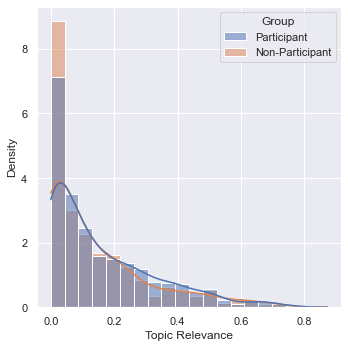

In [72]:
fig_df = df[index_filter(df, type='inter-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig_df = fig_df[fig_df['event_type'] == 'None']
fig_df = fig_df[fig_df['Position'] == 'Meteorologist']

print(fig_df['Group'].value_counts())

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

sns.histplot(fig_df, x='Topic Relevance', hue='Group', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel(xlabel='Topic Relevance')

fig.tight_layout()
plt.show()

In [73]:
a = fig_df[fig_df['group'] == 'Participant']['Topic Relevance'].mean()

In [74]:
b = fig_df[fig_df['group'] == 'Non-Participant']['Topic Relevance'].mean()

In [75]:
(a - b) * 100 / b

13.651048036511632

In [81]:
relevant_topics_cols

('Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas')

In [82]:
df.columns

Index(['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas',
       'Topic 3 - Forecast', 'Topic 4 - Forecast', 'Topic 5 - Forecast/Strom',
       'Topic 6 - Gas/Extreme'],
      dtype='object')

,id,type,group,index,subject_id,event_id,event_type,position,Topic Relevance,Group,EventType,Position
0,2494,intra-subject,Before,0,106299641910,115881228731,Joined,Meteorologist,0.000000,Before,Joined,Meteorologist
1,2495,intra-subject,After,0,106299641910,115881228731,Joined,Meteorologist,0.000000,After,Joined,Meteorologist
2,2496,intra-subject,Before,0,2067040562,327590147888,Joined,Meteorologist,0.298523,Before,Joined,Meteorologist
3,2497,intra-subject,After,0,2067040562,327590147888,Joined,Meteorologist,0.244761,After,Joined,Meteorologist
4,2498,intra-subject,Before,0,387950156117,521514204626,Joined,Meteorologist,0.000000,Before,Joined,Meteorologist
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4589,intra-subject,After,0,286416333904,970224796418,Joined,Meteorologist,0.278088,After,Joined,Meteorologist
2122,4616,intra-subject,Before,0,161989898448,951421577624,Joined,Met Producer,0.154393,Before,Joined,Meteorologist
2123,4617,intra-subject,After,0,161989898448,951421577624,Joined,Met Producer,0.723613,After,Joined,Meteorologist
2124,4618,intra-subject,Before,0,960956755008,544233187011,Joined,Meteorologist,0.000000,Before,Joined,Meteorologist


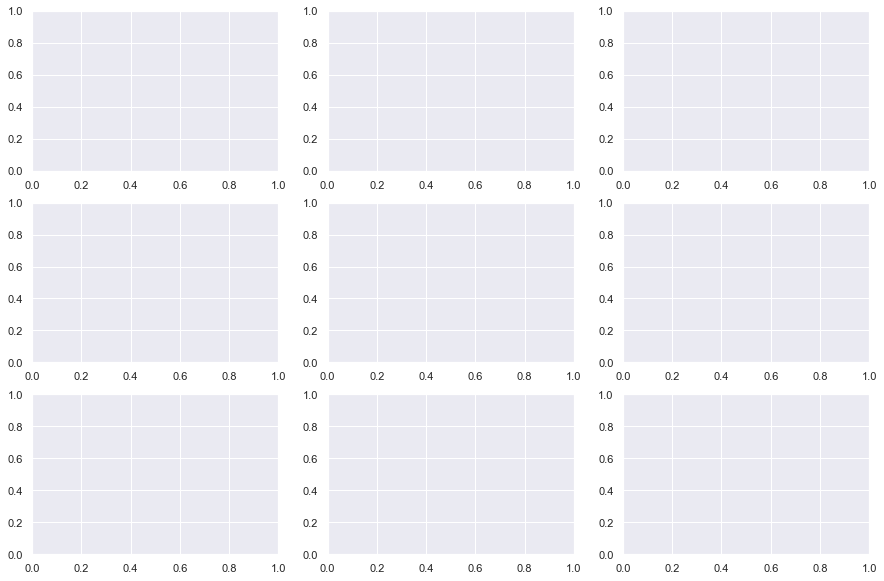

In [83]:
fig_df = df[index_filter(df, type='intra-subject')].loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df['EventType'] = fig_df['event_type']
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Joined')]

sub_fig_df

In [95]:
set(fig_df['EventType'].unique())

{'Joined', 'Workshop'}

{'Meteorologist', 'Reporter'}

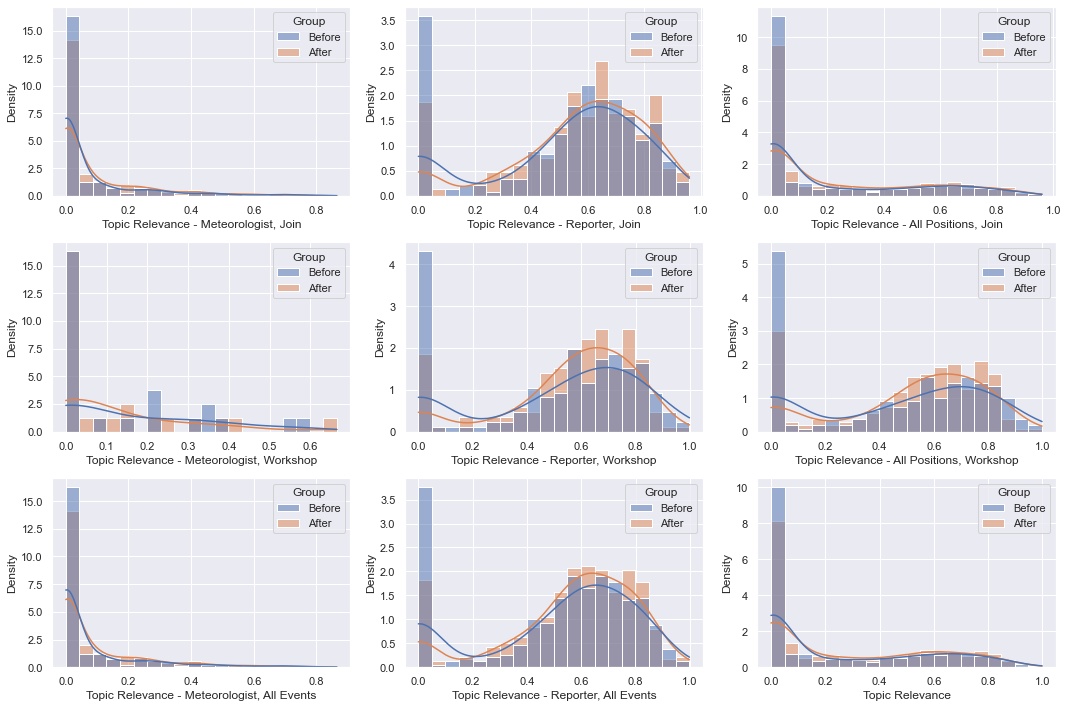

In [85]:
fig_df = df[index_filter(df, type='intra-subject')].loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])

fig_df['EventType'] = fig_df['event_type']
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Joined')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0][0])
axs[0][0].set_xlabel(xlabel='Topic Relevance - Meteorologist, Join')

sub_fig_df = fig_df[(fig_df['Position'] == 'Reporter') & (fig_df['EventType'] == 'Joined')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0][1])
axs[0][1].set_xlabel(xlabel='Topic Relevance - Reporter, Join')

sub_fig_df = fig_df[(fig_df['EventType'] == 'Joined')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0][2])
axs[0][2].set_xlabel(xlabel='Topic Relevance - All Positions, Join')

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Workshop')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1][0])
axs[1][0].set_xlabel(xlabel='Topic Relevance - Meteorologist, Workshop')

sub_fig_df = fig_df[(fig_df['Position'] == 'Reporter') & (fig_df['EventType'] == 'Workshop')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1][1])
axs[1][1].set_xlabel(xlabel='Topic Relevance - Reporter, Workshop')

sub_fig_df = fig_df[(fig_df['EventType'] == 'Workshop')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1][2])
axs[1][2].set_xlabel(xlabel='Topic Relevance - All Positions, Workshop')

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[2][0])
axs[2][0].set_xlabel(xlabel='Topic Relevance - Meteorologist, All Events')

sub_fig_df = fig_df[(fig_df['Position'] == 'Reporter')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[2][1])
axs[2][1].set_xlabel(xlabel='Topic Relevance - Reporter, All Events')

sub_fig_df = fig_df
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[2][2])
axs[2][2].set_xlabel(xlabel='Topic Relevance')

fig.tight_layout()
plt.show()

p value for norm = 1.554382605542929e-16
p value for exponweib = 1.5177454660828798e-26
p value for weibull_max = 5.7264627445750884e-08
p value for weibull_min = 1.5177454660825547e-26
p value for pareto = 1.517747435006794e-26


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for genextreme = 2.245774360442317e-72
Best fitting distribution: weibull_max
Best p value: 5.7264627445750884e-08
Parameters for the best fit: (60932588.68830912, 6340982.546482019, 6340982.474736085)
('weibull_max', 5.7264627445750884e-08, (60932588.68830912, 6340982.546482019, 6340982.474736085))


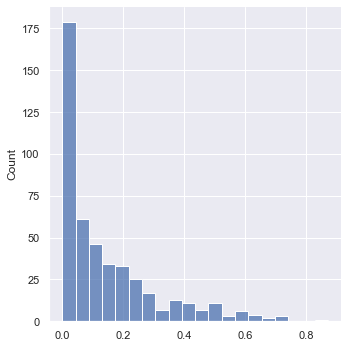

0.1409792519770531 0.16693707604587812 463
p value for norm = 5.467513448694415e-34
p value for exponweib = 3.100927494479822e-36
p value for weibull_max = 6.892357610511641e-15
p value for weibull_min = 3.100927494479822e-36


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 3.100927817200059e-36
p value for genextreme = 3.54413496921845e-16
Best fitting distribution: weibull_max
Best p value: 6.892357610511641e-15
Parameters for the best fit: (103478625.34022266, 11423571.73126958, 11423571.644426882)
('weibull_max', 6.892357610511641e-15, (103478625.34022266, 11423571.73126958, 11423571.644426882))


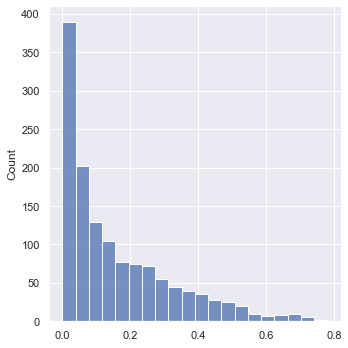

0.1583225376096787 0.16545460361826425 1339


In [330]:
groups_dfs = {
    group: df[index_filter(df, type='inter-subject', group=group, position='Meteorologist', event_type='None')] \
        .loc[:, relevant_topics_cols].sum(axis=1)
    for group in ['Participant', 'Non-Participant']
}

fig_df = groups_dfs['Non-Participant']

print(get_best_distribution(fig_df))

sns.displot(fig_df, facet_kws=dict(margin_titles=True), bins=20)

plt.show()

print(fig_df.mean(), fig_df.std(), fig_df.shape[0])

fig_df = groups_dfs['Participant']

print(get_best_distribution(fig_df))

sns.displot(fig_df, facet_kws=dict(margin_titles=True), bins=20)

plt.show()

print(fig_df.mean(), fig_df.std(), fig_df.shape[0])

Before
p value for norm = 3.7921412536064317e-06
p value for exponweib = 1.6033608456803416e-19
p value for weibull_max = 1.3456509542418597e-05
p value for weibull_min = 1.0812772271723996e-06
p value for pareto = 4.2301854326321904e-22


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for genextreme = 1.3406056692308103e-05
Best fitting distribution: weibull_max
Best p value: 1.3456509542418597e-05
Parameters for the best fit: (2.150421005438675, 1.0171743101968649, 0.6431131432231789)
('weibull_max', 1.3456509542418597e-05, (2.150421005438675, 1.0171743101968649, 0.6431131432231789))


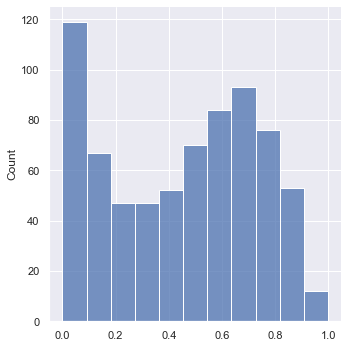

0.4484360824350506 0.28155843161703725 720
---
After
p value for norm = 1.0866529773678013e-07
p value for exponweib = 1.107064218694726e-33
p value for weibull_max = 5.031200996874546e-07
p value for weibull_min = 5.148879299339282e-14
p value for pareto = 6.080711320817326e-24


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


p value for genextreme = 2.2368484710761006e-73
Best fitting distribution: weibull_max
Best p value: 5.031200996874546e-07
Parameters for the best fit: (2.305001020926099, 1.0185324788239818, 0.6784905816486073)
('weibull_max', 5.031200996874546e-07, (2.305001020926099, 1.0185324788239818, 0.6784905816486073))


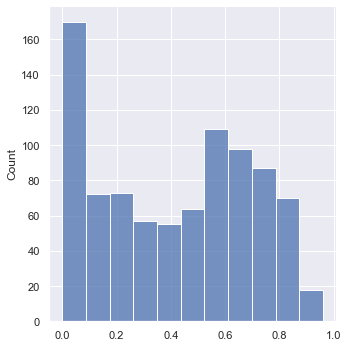

0.41845860746165486 0.28087073847940863 873


In [289]:
groups_dfs = {
    group: df[index_filter(df, type='intra-subject', group=group)] \
        .loc[:, relevant_topics_cols].sum(axis=1)
    for group in ['Before', 'After']
}

print('Before')

fig_df = groups_dfs['Before']

print(get_best_distribution(fig_df))

sns.displot(fig_df, facet_kws=dict(margin_titles=True),)

plt.show()

print(fig_df.mean(), fig_df.std(), fig_df.shape[0])

print('---')

print('After')

fig_df = groups_dfs['After']

print(get_best_distribution(fig_df))

sns.displot(fig_df, facet_kws=dict(margin_titles=True),)

plt.show()

print(fig_df.mean(), fig_df.std(), fig_df.shape[0])

In [290]:
sorted(df.index.get_level_values('index').unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [291]:
df[index_filter(df, type='intra-subject-consistency', group='After', )] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba')

,id,type,group,index,subject_id,event_id,event_type,position,proba
0,5097,intra-subject-consistency,After,1,2067040562,327590147888,Joined,Meteorologist,0.530724
1,5098,intra-subject-consistency,After,2,2067040562,327590147888,Joined,Meteorologist,0.078540
2,5099,intra-subject-consistency,After,3,2067040562,327590147888,Joined,Meteorologist,0.332303
3,5100,intra-subject-consistency,After,4,2067040562,327590147888,Joined,Meteorologist,0.349177
4,5101,intra-subject-consistency,After,5,2067040562,327590147888,Joined,Meteorologist,0.579767
...,...,...,...,...,...,...,...,...,...
8220,33285,intra-subject-consistency,After,7,850882780886,812321945858,Workshop,Journalist,0.407580
8221,33286,intra-subject-consistency,After,8,850882780886,812321945858,Workshop,Journalist,0.380052
8222,33287,intra-subject-consistency,After,9,850882780886,812321945858,Workshop,Journalist,0.477244
8223,33288,intra-subject-consistency,After,10,850882780886,812321945858,Workshop,Journalist,0.197991


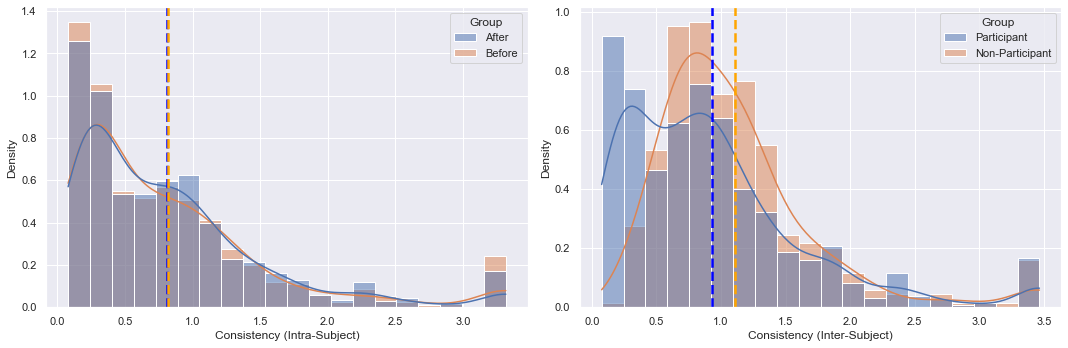

In [417]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

consistency_df = data_df.std(axis=1) / data_df.mean(axis=1)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0],
                hue_order=['After', 'Before'])
axs[0].set_xlabel(xlabel='Consistency (Intra-Subject)')
axs[0].axvline(x=sub_fig_df[sub_fig_df['Group']=='After']['Consistency'].mean(), 
               color='blue', ls='--', lw=2.5)
axs[0].axvline(x=sub_fig_df[sub_fig_df['Group']=='Before']['Consistency'].mean(), 
               color='orange', ls='--', lw=2.5)

# 

data_df = df[index_filter(df, type='inter-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

consistency_df = data_df.std(axis=1) / data_df.mean(axis=1)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1],
                hue_order=['Participant', 'Non-Participant'])
axs[1].set_xlabel(xlabel='Consistency (Inter-Subject)')
axs[1].axvline(x=sub_fig_df[sub_fig_df['Group']=='Non-Participant']['Consistency'].mean(), 
               color='orange', ls='--', lw=2.5)
axs[1].axvline(x=sub_fig_df[sub_fig_df['Group']=='Participant']['Consistency'].mean(), 
               color='blue', ls='--', lw=2.5)

fig.tight_layout()
plt.show()

In [418]:
sub_fig_df[sub_fig_df['group'] == 'Participant']['Consistency'].mean()

0.9283365804278476

In [420]:
sub_fig_df[sub_fig_df['group'] == 'Non-Participant']['Consistency'].mean()

1.108467931166926

In [412]:
data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

consistency_df = data_df.std(axis=1) / data_df.mean(axis=1)

data_df = consistency_df\
        .reset_index(drop=False, name='Consistency')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position']!='Other']

count_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Consistency'], aggfunc='count', margins=2)[['Consistency']]
pivot_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Consistency'], margins=2)[['Consistency']]

pivot_df.drop(labels=[('Consistency', 'All')], axis=1, inplace=True)

pivot_df['\\Delta'] = (pivot_df[('Consistency', 'Before')]-pivot_df[('Consistency', 'After')]) * 100 / pivot_df[('Consistency', 'Before')]

pivot_df = pivot_df.applymap("{0:.2f}".format)

pivot_df['Support'] = count_df.sum(axis=1)

print(pivot_df.to_latex())

\begin{tabular}{lllllr}
\toprule
    & {} & \multicolumn{2}{l}{Consistency} & \textbackslash Delta & Support \\
    & group &       After & \multicolumn{3}{l}{Before} \\
Event Type & Position &             &        &        &         \\
\midrule
Join & Meteorologist &        1.16 &   1.23 &   5.53 &    1318 \\
    & Reporter &        0.48 &   0.45 &  -6.75 &    1054 \\
Workshop & Meteorologist &        1.04 &   1.12 &   6.56 &      54 \\
    & Reporter &        0.60 &   0.69 &  13.33 &     582 \\
All &          &        0.82 &   0.83 &   1.33 &    3008 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_67041/2102006836.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_df.to_latex())
